# <center> SAE Velos de Nantes - Partie R2.08</center>

<center> BASOL Nathan - LEDERREY Lussandre - MACCREZ Allan </center>

A partir de la base de données MySQL sur les vélos de Nantes, nous allons valoriser des données en produisant différents indicateurs graphiques. Chaque indicateur répondera à une question precise.



> Importation des packages et modules nécessaires

In [1]:
# importation des packages
import numpy as np
import pandas as pd

# importation des modules
import matplotlib.pyplot as plt
import scipy.stats as sps
import mysql.connector

# warning
import warnings
warnings.filterwarnings('ignore')

> Connexion à la base de données et affichage des tables

In [2]:
# connexion à la base de données
cnx = mysql.connector.connect(user='root', password='basolympe2004', host='127.0.0.1', database='bd_velos_nantes', charset='utf8')

# création du curseur
mycursor = cnx.cursor() 

# affichage des tables
mycursor.execute("SHOW TABLES")

# récupérer toutes les lignes du résultat de la requête
myresult = mycursor.fetchall() 

# afficher les tables
for x in myresult: 
    print(x)  

('comptage',)
('compteur',)
('dateinfo',)
('quartier',)


> Question 1 : Les pistes cyclable de nantes ont elles eu une augmentation d'utilisation sur la période 2020 - 2022 ?

In [3]:
# requête 1 : nombre de vélos par année
requete1 = """
SELECT YEAR(laDate) AS annee, SUM(h00+h01+h02+h03+h04+h05+h06+h07+h08+h09+h10+h11+h12+h13+h14+h15+h16+h17+h18+h19+h20+h21+h22+h23) AS nbVelo
FROM DateInfo, Comptage
WHERE laDate = dateComptage
AND laDate BETWEEN '2020-01-01' AND '2022-12-31'
GROUP BY annee;
"""

# Exécuter la requête
df1 = pd.read_sql(requete1, cnx)

# Afficher le résultat
df1.head()

,annee,nbVelo
0,2020,9250011.0
1,2021,11592739.0
2,2022,13069986.0


> Affichage du résultat de la requête 1

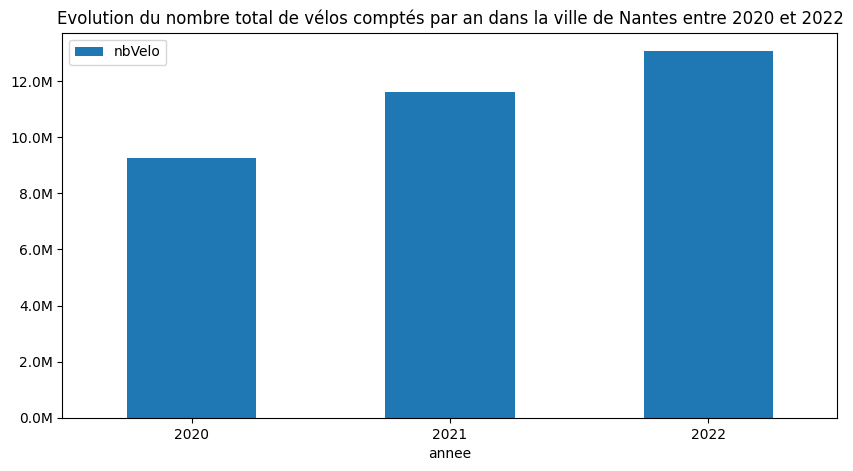

In [4]:
# Convertir les valeurs en millions
df1['nbVelo'] = df1['nbVelo'] / 1000000

# Créer le diagramme en barres
ax = df1.plot.bar(x='annee', y='nbVelo', rot=0, title="Evolution du nombre total de vélos comptés par an dans la ville de Nantes entre 2020 et 2022", figsize=(10, 5))

# Changer l'échelle de l'axe y en millions
ax.set_yticklabels(['{:.1f}M'.format(x) for x in ax.get_yticks()])

# Afficher le diagramme
plt.show()

> Réponse à la question 1


<span style="color:yellow;">Il y a eu une évolution croissante de l'utilisation des pistes cyclables de la ville de Nantes entre 2020 et 2022. On compte environ 2 millions de passages en plus par années. Ce pic est certainement lié à la crise sanitaire et aux confinements qui ont eu lieux en 2020. Forcément, l'utilisation des vélos a augmenté les années suivantes.</span>

> Question 2 : Quels sont les quartiers dans lesquels il y a eu le plus de présence d'anomalies fortes ?

In [5]:
# requête 2 : nombre présence anomalie forte par quartier en 2021
requete2 = """
SELECT nomQuartier, COUNT(presenceAnomalie) as nbPresencesAnomalies
FROM Comptage, Compteur, Quartier
WHERE Comptage.leCompteur = Compteur.idCompteur
AND Compteur.leQuartier = Quartier.idQuartier
AND UPPER(presenceAnomalie) = 'FORTE'
GROUP BY nomQuartier
ORDER BY nbPresencesAnomalies DESC;
"""

# Exécuter la requête
df2 = pd.read_sql(requete2, cnx)

# Afficher le résultat
print("Nombre de présences d'anomalies fortes par quartier :")
df2.head()


Nombre de présences d'anomalies fortes par quartier :


,nomQuartier,nbPresencesAnomalies
0,Malakoff - Saint-Donatien,794
1,Centre Ville,496
2,Dervalli�res - Zola,117
3,Ile de Nantes,103
4,Pont Rousseau,74


> Affichage du résultat de la requête 2

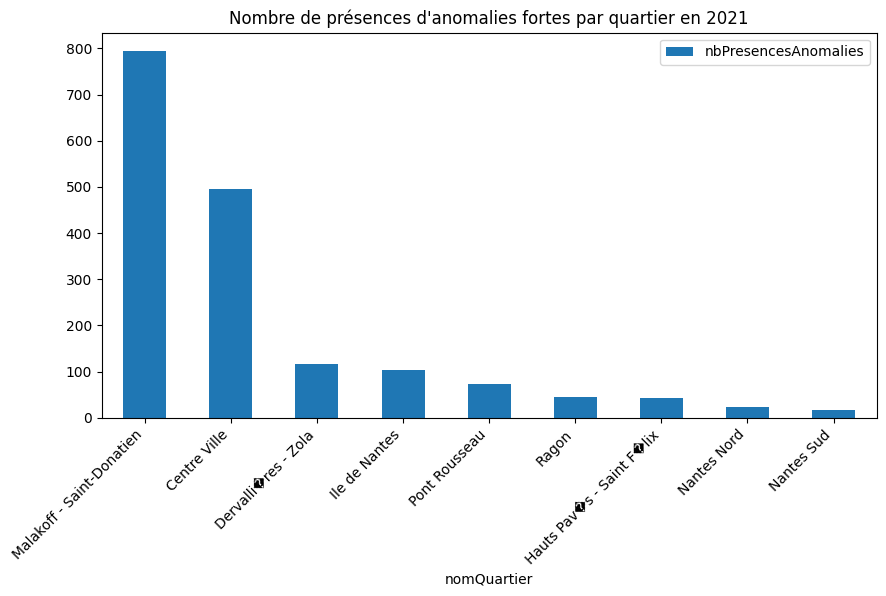

In [6]:
# diagramme en barres
df2.plot.bar(x='nomQuartier', y='nbPresencesAnomalies', rot=0, title="Nombre de présences d'anomalies fortes par quartier en 2021", figsize=(10,5))

# Récupérer l'objet Axes
ax = plt.gca()

# Pivoter les textes sur l'axe des abscisses à 45 degrés
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Afficher le graphique
plt.show()

> Réponse à la question 2


<span style="color:yellow;">On peut voir que les quartiers où il y a eu le plus d'anomalies fortes sont les quartiers de malakoff et du centre ville. On pourrait donc se dire que ces quartiers là possèdent des compteurs déféctueux. Cependant, il faut prendre en compte le fait que tout les quartiers de Nantes ne sont pas autant fréquentés que les autres. Il faudrait donc faire une analyse plus poussé en se demandant si certains quartiers semblent avoir des compteurs défectueux par rapport à la moyenne globale.</span>

> Question 3 : Est ce que certains quartiers ont des compteurs qui sembles déféctueux par rapport à la moyenne ?

In [7]:
# requête 3a  : nombre moyen d'anomalies fortes par quartier
requete3a = """
SELECT(SELECT COUNT(presenceAnomalie) AS nbAnomaliesFortes
       FROM Comptage
       WHERE presenceAnomalie = 'FORTE') /
      (SELECT COUNT(idCompteur) AS nbCompteurs
       FROM Compteur) AS nbAnomaliesFortesMoyenneParQuartier;
"""

# Exécuter la requête
df3a = pd.read_sql(requete3a, cnx)

# Afficher le résultat
print("Nombre moyen d'anomalies fortes par quartier : ")
df3a.head()

Nombre moyen d'anomalies fortes par quartier : 


,nbAnomaliesFortesMoyenneParQuartier
0,29.5172


In [8]:
# requête 3b : quartier avec nombre d'anomalies fortes supérieur à la moyenne
requete3b = """
SELECT nomQuartier, COUNT(presenceAnomalie) as nbPresencesAnomalies, COUNT(DISTINCT idCompteur) AS nbCompteurs, COUNT(presenceAnomalie) / COUNT(DISTINCT idCompteur) as nbAnoParCpt
FROM Comptage, Compteur, Quartier
WHERE Comptage.leCompteur = Compteur.idCompteur
AND Compteur.leQuartier = Quartier.idQuartier
AND presenceAnomalie = 'FORTE'
GROUP BY nomQuartier
HAVING COUNT(presenceAnomalie) / COUNT(DISTINCT idCompteur) > (SELECT(SELECT COUNT(presenceAnomalie) AS nbAnomaliesFortes
                                                               FROM Comptage
                                                               WHERE presenceAnomalie = 'FORTE') /
                                                               (SELECT COUNT(idCompteur) AS nbCompteurs
                                                               FROM Compteur) AS nbAnomaliesFortesMoyenneParQuartier);
"""

# Exécuter la requête
df3 = pd.read_sql(requete3b, cnx)

# Afficher le résultat
print("Quartiers avec un nombre d'anomalies fortes par compteurs supérieur à la moyenne :")
df3.head()

Quartiers avec un nombre d'anomalies fortes par compteurs supérieur à la moyenne :


,nomQuartier,nbPresencesAnomalies,nbCompteurs,nbAnoParCpt
0,Dervalli�res - Zola,117,1,117.0000
1,Malakoff - Saint-Donatien,794,7,113.4286
2,Pont Rousseau,74,2,37.0000


> Réponse question 3



<span style="color:yellow;">Il serait donc utile d'aller vérifier et réparer les compteurs dans les quartiers de Zola, Malakoff-Saint-Donatien et Pont Rousseau. Le centre ville possède certes beaucoup d'anomalies fortes, mais c'est un quartier qui possède aussi beaucoup de compteurs donc il n'y a pas de problème.</span>

> Question 4 : Est ce que tout les quartiers possèdent des compteurs ?

In [9]:
# requête 4 : nombre de compteurs par quartier
requete4 = """
SELECT nomQuartier, COUNT(idCompteur) AS nbCompteurs
FROM Quartier 
    LEFT JOIN Compteur ON Quartier.idQuartier = Compteur.leQuartier
GROUP BY nomQuartier
ORDER BY nbCompteurs DESC;
"""

# Exécuter la requête
df4 = pd.read_sql(requete4, cnx)

# Afficher le résultat
print(df4)

                           nomQuartier  nbCompteurs
0                         Centre Ville           22
1            Malakoff - Saint-Donatien            9
2                        Ile de Nantes            6
3            Hauts Pav�s - Saint F�lix            4
4                          Nantes Nord            2
5                    Doulon - Botti�re            2
6                           Nantes Sud            2
7                        Pont Rousseau            2
8                                Ragon            2
9                  Dervalli�res - Zola            1
10  Bellevue - Chantenay - Sainte Anne            0
11                    Breil - Barberie            0
12                        Nantes Erdre            0
13                         Trentemoult            0
14                      H�tel de Ville            0
15                     Ch�teau de Rez�            0
16                         La Houssais            0
17                           Blordi�re            0


> Réponse à la question 4


<span style="color:yellow;">Non, beaucoup de quartier n'ont aucun compteur. Seulement 10 quartiers en possèdent. Le centre ville possède beaucoup de compteurs par rapport aux autres quartiers. Il serait donc intéressant de se demander si il faut rajouter des compteurs dans les quartiers qui n'en possèdent pas.</span>

> Question 5 : Faut il rajouter des compteurs dans les quartiers qui n'en possèdent pas ?

In [68]:
# requête 5a : longueur totale des pistes cyclables pour tous les quartiers
requete5a = """
SELECT SUM(longueurPisteVelo) AS longueurTotalPisteVelo
FROM Quartier;
"""

# Exécuter la requête
df5a = pd.read_sql(requete5a, cnx)

# Afficher le résultat
print("Longueur totale des pistes cyclables pour tous les quartiers : ")
df5a.head()


Longueur totale des pistes cyclables pour tous les quartiers : 


,longueurTotalPisteVelo
0,329131.197754


In [69]:
# requête 5b : longueur totale des pistes cyclables pour les quartiers sans compteur
requete5b = """
SELECT SUM(longueurPisteVelo) AS longueurTotalPisteVelo
FROM Quartier 
    LEFT JOIN Compteur ON Quartier.idQuartier = Compteur.leQuartier
WHERE idCompteur IS NULL;
"""

# Exécuter la requête
df5b = pd.read_sql(requete5b, cnx)

# Afficher le résultat
print()
print("Longueur totale des pistes cyclables pour les quartiers sans compteur : ")
df5b.head()


Longueur totale des pistes cyclables pour les quartiers sans compteur : 


,longueurTotalPisteVelo
0,104143.699219


In [70]:
# requête 4c : ratio de la longueur totale des pistes cyclables pour les quartiers sans compteur
requete5c = """
SELECT (SELECT SUM(longueurPisteVelo) AS longueurTotalPisteVelo
        FROM Quartier
        LEFT JOIN Compteur ON Quartier.idQuartier = Compteur.leQuartier
        WHERE idCompteur IS NULL) /
       (SELECT SUM(longueurPisteVelo) AS longueurTotalPisteVelo
        FROM Quartier) *100 AS ratio;
"""

# Exécuter la requête
df5c = pd.read_sql(requete5c, cnx)

# Afficher le résultat
print()
print("Ratio de la longueur totale des pistes cyclables pour les quartiers sans compteur : ")
df5c.head()


Ratio de la longueur totale des pistes cyclables pour les quartiers sans compteur : 


,ratio
0,31.642002


(-1.1868428673146518,
 1.1041352180055488,
 -1.1028095356293546,
 1.1590187120607216)

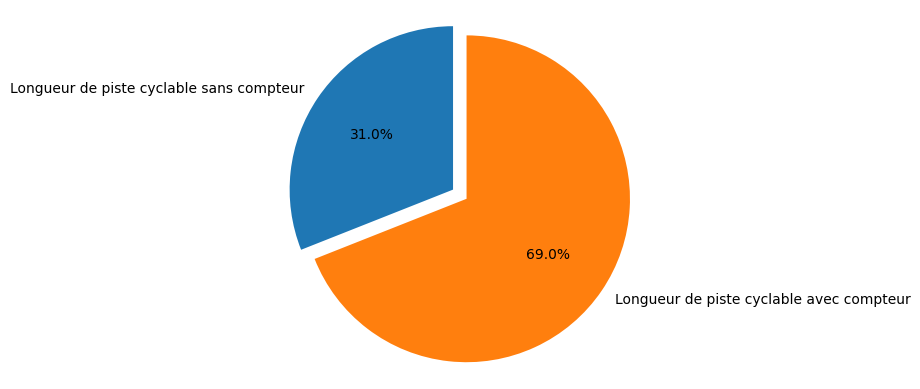

In [73]:
# graphique diagramme circulaire
labels = 'Longueur de piste cyclable sans compteur', 'Longueur de piste cyclable avec compteur'
sizes = [31, 69]
explode = (0.1, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)
ax1.axis('equal')


> Réponse à la question 5


<span style="color:yellow;">Il y a donc environ 31% de piste cyclable qui n'est pas comptabilisé par un capteur. Il serait donc intéressant de rajouter des compteurs dans les quartiers qui n'en possèdent pas. Il faudrait en priporité privilégier les plus longues pistes cyclables. Pour cela, voici une requête qui nous les montres.</span>

In [89]:
# requête 5d : longueur des pistes cyclables pour chaque quartier sans compteur
requete5d = """
SELECT nomQuartier, SUM(longueurPisteVelo) AS longueurTotalPisteVelo
FROM Quartier
    LEFT JOIN Compteur ON Quartier.idQuartier = Compteur.leQuartier
WHERE idCompteur IS NULL
GROUP BY nomQuartier
ORDER BY longueurTotalPisteVelo DESC;
"""

# Exécuter la requête
df5d = pd.read_sql(requete5d, cnx)

# Afficher le résultat
print()
print("Longueur totale des pistes cyclables pour les quartiers sans compteur : ")
print(df5d)


Longueur totale des pistes cyclables pour les quartiers sans compteur : 
                          nomQuartier  longueurTotalPisteVelo
0                        Nantes Erdre            31816.199219
1  Bellevue - Chantenay - Sainte Anne            22597.300781
2                    Breil - Barberie            16718.199219
3                         La Houssais             9288.900391
4                         Trentemoult             7854.500000
5                     Ch�teau de Rez�             6371.500000
6                      H�tel de Ville             4808.799805
7                           Blordi�re             4688.299805


<span style="color:yellow;">Il faut donc rajouter des compteurs en priorité dans les quartiers de Nantes Erdre, Bellevue-Chantenay-Sainte Anne et Breil-Barberie.</span>

> Question 6 : 